In [100]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import os
import json
import ome_types
import numpy as np
import pandas as pd
from pathlib import Path
#from PIL import Image
#import PIL
#from PIL.TiffTags import TAGS
import tifffile as tiff
from bs4 import BeautifulSoup
import os
from uuid import uuid4
import copy
#from tiff import TiffData
#from ome_types import from_tiff,to_xml
from ome_types.model import OME,Image,Instrument,Pixels,TiffData,Channel,Plane,Pixels_DimensionOrder
from ome_types.model.simple_types import PixelsID
from ome_types.model.pixels import DimensionOrder
import ome_types
import ome_types.model
import platform
import argparse
from ome_types import to_xml
import re

In [86]:
# read in all xml files and extract and print the Print size parameter from it
xml_file = './../../../../data/Human_squamous_cell_carcinoma_stained_with_SignalStar_mIHC_technology/test/metadata.xml'
def extract_print_size(xml_file):
    try:
        with open(xml_file, 'r') as f:
            metadata = f.read()
        
        # Use regex to find the Print size value
        pattern = r"Print size: (\d+\.\d+x\d+\.\d+)"
        match = re.search(pattern, metadata)
        if match:
            print_size = match.group(1)
            print(f"Print Size: {print_size}")
            return print_size
        else:
            print("Print Size not found in metadata.")
            return None
    
    except FileNotFoundError:
        print(f"Error: File {xml_file} not found.")
        return None

# Example usage:
#xml_file = './../../../../data/Human_squamous_cell_carcinoma_stained_with_SignalStar_mIHC_technology/test/metadata.xml'
print_size = extract_print_size(xml_file)

# Now you can use the print_size variable as needed
if print_size:
    # Example: Splitting print_size into width and height
    print_width, print_height = map(float, print_size.split('x'))
    print(f"Width: {print_width}, Height: {print_height}")

Print Size: 0.0927855x0.069639
Width: 0.0927855, Height: 0.069639


In [7]:
# Path to TIFF file
#tif_file_path = './../../../../data/Human_squamous_cell_carcinoma_stained_with_SignalStar_mIHC_technology/test/SCC_T37C_T1_Scan1_[10838,39481]_component_data.tif'

# path to all tif files that I want to extract metadata information from
input_dir = './../../../../data/Human_squamous_cell_carcinoma_stained_with_SignalStar_mIHC_technology/test/'
# Make a list of all files with a ".tif" extension in the input directory
input_files = [os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith('.tif')]
# Sort the list of files alphabetically
input_files = sorted(input_files)

In [87]:
# Extract metadata information from all tifffiles
def process_tiff_file(tif_file_path):
    # List to store metadata for each page
    metadata_list = []
    
    # Open the TIFF file
    with tiff.TiffFile(tif_file_path) as tif:
        # Iterate over all pages (IFDs) in the TIFF file
        for i, page in enumerate(tif.pages):
            if i >= 6:
                break
            # Dictionary to hold metadata for the current page
            page_metadata = {
                "page_index": i,
                "image_width": page.imagewidth,
                "image_length": page.imagelength,
                "bits_per_sample": page.bitspersample,
                "x_position": None,
                "y_position": None,
                "z_position": i,
                "image_description": None,
                "marker": None,
                "exposure_time": None,
                "signal_unit": None,
                #"pixel_unit": None,
                "device_name": None, 
                "no_of_channels": None,
                "pixel_size" : 20046.2,
                #"physical_size_y" : 20046.2,
                "pixel_unit" : "PixelsPerCentimeter"
            }
            #print(page.tags)
            
            # Extract position information
            x_position = page.tags.get('XPosition')
            y_position = page.tags.get('YPosition')
            if x_position and y_position:
                page_metadata["x_position"] = x_position.value[0] / x_position.value[1]
                page_metadata["y_position"] = y_position.value[0] / y_position.value[1]

            # Extract more information stored in xml format
            xml_string = page.tags.get('ImageDescription').value
            root = ET.fromstring(xml_string)

            # Extract <Name> tag
            name_element = root.find('./Name')
            if name_element is not None:
                page_metadata["marker"] = name_element.text

            # Extract <ExposureTime> tag
            exposure_time_element = root.find('./ExposureTime')
            if exposure_time_element is not None:
                page_metadata["exposure_time"] = exposure_time_element.text

            # Extract <SignalUnits> tag
            signal_units_element = root.find('./SignalUnits')
            if signal_units_element is not None:
                page_metadata["signal_unit"] = signal_units_element.text

            # Extract <SlideID> tag
            #positions_element = root.find('./SlideID')
            #if positions_element is not None:
            #    match = re.search(r'\[(\d+),(\d+)\]', positions_element.text)
            #    if match:
            #        page_metadata["x_position"] = int(match.group(1))
             #       page_metadata["y_position"] = int(match.group(2))

            # Extract <PixelUnits> tag within <ScanProfile>
            scan_profile = root.find('.//ScanProfile')
            if scan_profile is not None:
                pixel_units_element = scan_profile.find('.//root')
                if pixel_units_element is not None:
                    pixel_units_element = scan_profile.find('.//PixelUnits')
                    if pixel_units_element is not None:
                        page_metadata["pixel_unit"] = pixel_units_element.text

            # Append the page metadata to the list
            metadata_list.append(page_metadata)
    
    return metadata_list

# Process all TIFF files in the input directory
all_tile_metadata = []
for tif_file_path in input_files:
    tile_metadata = process_tiff_file(tif_file_path)
    all_tile_metadata.append(tile_metadata)

all_tile_metadata


[[{'page_index': 0,
   'image_width': 1860,
   'image_length': 1396,
   'bits_per_sample': 32,
   'x_position': 1.0373097659783452,
   'y_position': 3.9132745276156955,
   'z_position': 0,
   'image_description': None,
   'marker': 'Alexa 488',
   'exposure_time': '9300',
   'signal_unit': '33',
   'device_name': None,
   'no_of_channels': None,
   'pixel_size': 20046.2,
   'pixel_unit': 'pu_NormalizedCounts'},
  {'page_index': 1,
   'image_width': 1860,
   'image_length': 1396,
   'bits_per_sample': 32,
   'x_position': 1.0373097659783452,
   'y_position': 3.9132745276156955,
   'z_position': 1,
   'image_description': None,
   'marker': 'Alexa 594',
   'exposure_time': '10310',
   'signal_unit': '33',
   'device_name': None,
   'no_of_channels': None,
   'pixel_size': 20046.2,
   'pixel_unit': 'PixelsPerCentimeter'},
  {'page_index': 2,
   'image_width': 1860,
   'image_length': 1396,
   'bits_per_sample': 32,
   'x_position': 1.0373097659783452,
   'y_position': 3.9132745276156955,


In [88]:
#list markers of the files

markers = []
for i in range(0,6):
    marker = all_tile_metadata[0][i]['marker']
    markers.append(marker)

markers

['Alexa 488', 'Alexa 594', 'Alexa 647', 'Cy7', 'DAPI', 'Autofluorescence']

In [96]:
#adapt Victors function for creating the ome structure
#!/usr/bin/python

def create_ome(all_tile_metadata,img_path):
    img_name= "test"
    no_of_channels=len(all_tile_metadata[0])
    bits_per_sample=all_tile_metadata[0][0]['bits_per_sample']
    no_of_tiles=len(all_tile_metadata)
    tiff.tiffcomment(img_path,'')
    #--Generate tiff_data_blocks--#
    tiff_block=[]
    #uuid_obj=UUID(file_name=img_name,value=uuid4().urn)
    for ch in range(0,no_of_channels):
        tiff_block.append(TiffData(first_c=ch,
                                    ifd=ch,
                                    plane_count=1#,
                                    #uuid=uuid_obj
                                )
                         
                         )
    #--Generate planes block (contains the information of each tile)--#
    plane_block=[]
    #length_units=ome_types.model.simple_types.UnitsLength('µm')
    for ch in range(0,no_of_channels):
        plane_block.append(Plane(the_c=ch,
                                 the_t=0,
                                 the_z=0,
                                 position_x=0,#x=0 is just a place holder
                                 position_y=0,#y=0 is just a place holder
                                 position_z=0,
                                 exposure_time=0
                                 #position_x_unit=pixel_units,
                                 #position_y_unit=pixel_units
                                )
                          )
    #--Generate channels block--#
    chann_block=[]
    #for ch in range(0,no_of_channels):
    for ch,chann_name in enumerate(markers):
        chann_block.append(Channel(id=ome_types.model.simple_types.ChannelID('Channel:{x}'.format(x=ch)),
                                name=chann_name,
                                color=ome_types.model.simple_types.Color((255,255,255)),
                                emission_wavelength=1,#place holder
                                excitation_wavelength=1,#place holder
                                  )
                          )
    #--Generate pixels block--#
    pix_block=[]
    ifd_counter=0
    for t in range(0,no_of_tiles):
        template_plane_block=copy.deepcopy(plane_block)
        template_chann_block=copy.deepcopy(chann_block)
        template_tiffdata_block=copy.deepcopy(tiff_block)
        for ch, mark in enumerate(markers):
            template_plane_block[ch].position_x=int(round(all_tile_metadata[t][0]['x_position']*10000))
            template_plane_block[ch].position_y=int(round(all_tile_metadata[t][0]['y_position']*10000))
            template_plane_block[ch].exposure_time=all_tile_metadata[t][ch]['exposure_time']
            template_chann_block[ch].id='Channel:{y}:{x}'.format(x=ch,y=100+t) ### why?
            template_chann_block[ch].name=mark
            template_tiffdata_block[ch].ifd=ifd_counter
            ifd_counter+=1
        pix_block.append(Pixels(id=ome_types.model.simple_types.PixelsID('Pixels:{x}'.format(x=t)),
                                dimension_order=ome_types.model.pixels.DimensionOrder('XYCZT'), ### check if the order is correct!!
                                size_c=no_of_channels,
                                size_t=1,
                                size_x=all_tile_metadata[t][0]['image_width'],
                                size_y=all_tile_metadata[t][0]['image_length'],
                                size_z=1,
                                type=ome_types.model.pixels.PixelType('uint32'),
                                #type=bit_depth,
                                big_endian=False,
                                channels=template_chann_block,
                                interleaved=False,
                                physical_size_x=(print_width/all_tile_metadata[t][0]['image_width'])*10000,
                                physical_size_y=(print_height/all_tile_metadata[t][0]['image_length'])*10000,
                                #physical_size_x=pixel_size,
                                #physical_size_x_unit=pixel_units,
                                #physical_size_y=pixel_size,
                                #physical_size_y_unit=pixel_units,
                                physical_size_z=1.0,
                                planes=template_plane_block,
                                bits_per_sample=bits_per_sample,
                                tiff_data_blocks=template_tiffdata_block
                               )
                        )
    #--Generate image block--#
    img_block=[]
    for t in range(0,no_of_tiles):
        img_block.append(Image(id=ome_types.model.simple_types.ImageID('Image:{x}'.format(x=t)),
                               pixels=pix_block[t]
                              )
                        )
    #--Create the OME object with all previously defined blocks--#
    ome_custom=OME()
    ome_custom.creator=" ".join([ome_types.__name__,
                                 ome_types.__version__,
                                 '/ python version-',
                                 platform.python_version()
                                ]
                               )
    ome_custom.images=img_block
    ome_custom.uuid=uuid4().urn
    ome_xml=to_xml(ome_custom)
    tiff.tiffcomment(img_path,ome_xml)


In [115]:
img_path = './../../../../data/Human_squamous_cell_carcinoma_stained_with_SignalStar_mIHC_technology/numpy_stacked_output_uint16.tif'
create_ome(all_tile_metadata,img_path)


/var/folders/79/cjwcycvd2_9dyfffbym60x200000gn/T/ipykernel_40738/369620917.py:2: UserWarning: Unrecognized fields for type <class 'ome_types._autogenerated.ome_2016_06.pixels.Pixels'>: {'bits_per_sample'}
  create_ome(all_tile_metadata,img_path)


Text(0.5, 1.0, 'Tile positions')

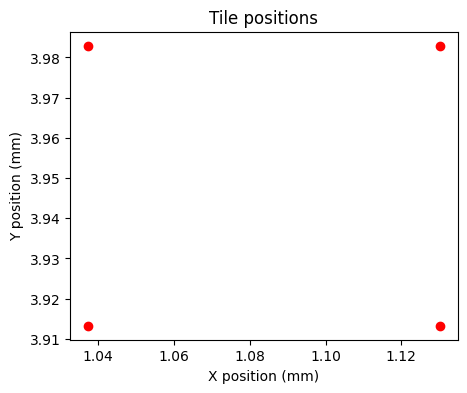

In [48]:
# plot manually given x and y positions in a scatter plot
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
plt.figure(figsize=(5, 4))
plt.scatter([all_tile_metadata[i][0]['x_position'] for i in range(4)], [all_tile_metadata[i][0]['y_position'] for i in range(4)], c='r', label='Tile positions')
plt.xlabel('X position (mm)')
plt.ylabel('Y position (mm)')
plt.title('Tile positions')

## Keep for now but delete later (metadata brainstorm)

In [ ]:
#try Wand package, like ImageMagick

from wand.image import Image

def get_image_info(image_path):
    with Image(filename=image_path) as img:
        info = {
            'format': img.format,
            'size': (img.width, img.height),
            'depth': img.depth,
            'colorspace': img.colorspace,
            'compression': img.compression,
            'units': img.units,
            'resolution': (img.resolution[0], img.resolution[1]),
        }
        return info

if __name__ == "__main__":
    image_path = "image.tiff"
    image_info = get_image_info(image_path)
    for key, value in image_info.items():
        print(f"{key}: {value}")

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        metadata = {
            TAGS[key]: value
            for key, value in img.info.items()
            if isinstance(value, (int, float, str, bytes))
        }
        return metadata

if __name__ == "__main__":
    #image_path = "SCC_T37C_T1_Scan1_[10838,39481]_component_data.tif"
    metadata = get_image_metadata(tif_file_path)
    for key, value in metadata.items():
        print(f"{key}: {value}")


In [ ]:
# Open the image file
img = Image.open(tif_file_path)

# Get detailed image info
info = img.info
info

In [ ]:
import exifread

# Open image file for reading (binary mode)
with open(tif_file_path, 'rb') as f:
    tags = exifread.process_file(f)

# Print all tags
for tag in tags.keys():
    print(f"{tag}: {tags[tag]}")